In [8]:
import os
import sys
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tensorflow import keras

project_root = os.path.abspath("..")
sys.path.append(project_root)

from src.dataset_no_context import DataGen
from src.models.MaskGenerator_No_Context import MaskGenerator
from src.models.UNETO_CELTIC import UNet3D
from src.models.fnet_model import CELTICModel
from src.transforms import normalize, normalize_with_mask, Propper


In [9]:
class Wrapper(nn.Module):
    def __init__(self, celtic_model):
        super().__init__()
        self.model = celtic_model
        self.model.net.eval()
        for param in self.model.net.parameters():
            param.requires_grad = False  # Freeze weights

    def forward(self, signal: torch.Tensor, m = None):
        pred = self.model.net(signal)
        pred = pred * m
        return pred


In [10]:
all_organelles = ["Nucleolus-(Granular-Component)", "Nuclear-envelope", "Mitochondria", "Actin-filaments",
                 "Endoplasmic-reticulum", "Plasma-membrane", "Microtubules"]

In [11]:
# Define base path for all operations
BASE_PATH = os.path.dirname(os.getcwd())
print(BASE_PATH)

C:\Users\gadmi\Desktop\University Files\Meitar\Thesis\Paper\GitHub\repo\single_cell


In [12]:
# --- Configuration ---
weighted_pcc = False
signals_are_masked = True
organelle = all_organelles[1]

unet_model_path = f"{BASE_PATH}/models/unet/{organelle}/best_model_no_context.p"
mg_model_path = f"{BASE_PATH}/models/mg/{organelle}/model_no_context.pt"
data_path = f"{BASE_PATH}/data/{organelle}/cells"
test_csv_path = f"{BASE_PATH}/data/{organelle}/metadata/test_images.csv"
patch_size = (32, 64, 64, 1)


In [13]:
# --- Load context config ---
with open(f"{BASE_PATH}/models/unet/{organelle}/context_model_config.json", 'r') as file:
    context_model_config = json.load(file)


In [14]:
transforms_config = context_model_config["transforms"]

# Evaluate each string in the config using `eval`, injecting train_patch_size
transforms = {
    k: eval(v, {"normalize": normalize,
                "normalize_with_mask": normalize_with_mask,
                "Propper": Propper,
                "train_patch_size": patch_size[:-1]})
    for k, v in transforms_config.items()
}

In [15]:
# === Load Datasets ===
test_dataset = DataGen(test_csv_path, data_path, transforms, signals_are_masked)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [16]:
# === Initialize Models ===
unet = UNet3D(in_channels=2, out_channels=1)


In [17]:
%%capture
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Load CELTIC model ---
model = CELTICModel(context=None, signals_are_masked=signals_are_masked)
model.load_state(unet_model_path)
model_wrapper = Wrapper(model)

model.net.eval()

# --- Load Mask model ---
mg = MaskGenerator(patch_size, unet, model_wrapper, mask_loss_weight=0.9, weighted_pcc=weighted_pcc,
                   pcc_target=0.89)
mg.load_state_dict(torch.load(mg_model_path, map_location=device))

mg.eval()


In [18]:
%%capture

model.net.to(device)
mg.to(device)

In [19]:
# To get a specific row in the dataset
row_number = 0

# Get images
x, y, m = test_dataset[row_number]

# Add batch size and make torch
x = torch.from_numpy(np.expand_dims(x, axis=0))
y = torch.from_numpy(np.expand_dims(y, axis=0))
m = torch.from_numpy(np.expand_dims(m, axis=0))

# Move to device if needed
x, y, m = x.to(device), y.to(device), m.to(device)

# Run through the model
with torch.no_grad():
    prediction = model_wrapper(x, m)


In [20]:
with torch.no_grad():
    x_input = torch.cat([
        F.relu(F.conv3d(x, weight=torch.ones(1, x.shape[1], 3, 3, 3).to(device), padding=1)),
        F.relu(F.conv3d(prediction, weight=torch.ones(1, prediction.shape[1], 3, 3, 3).to(device), padding=1))
    ], dim=1).to(device)


In [21]:
mask = mg.mask_net(x_input)


In [22]:
mask.shape


torch.Size([1, 1, 32, 224, 352])

In [23]:
input_patch = x.detach().cpu()
target_patch = y.detach().cpu()
pred = prediction.detach().cpu()
mask_prediction = mask.detach().cpu()


In [24]:
threshold = 0.4
binary_mask = (mask_prediction > threshold).float()

(-0.5, 351.5, 223.5, -0.5)

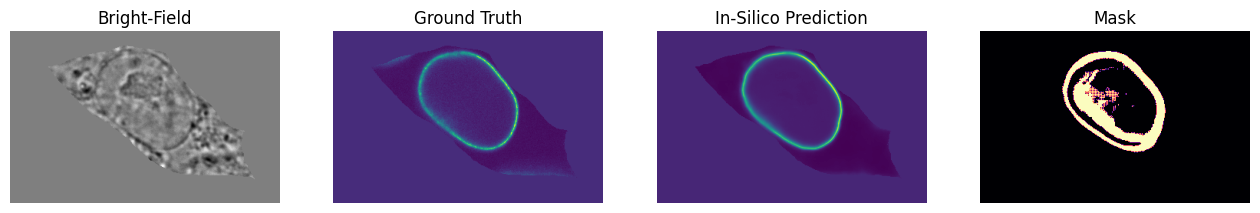

In [25]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 5))
zs = int(mask.shape[2]/2)
ax1.imshow(input_patch[0,0,zs,:,:], cmap='gray')
ax1.set_title('Bright-Field')
ax1.axis('off')
ax2.imshow(target_patch[0,0,zs,:,:], cmap='viridis')
ax2.set_title('Ground Truth')
ax2.axis('off')
ax3.imshow(pred[0,0,zs,:,:], cmap='viridis')
ax3.set_title('In-Silico Prediction')
ax3.axis('off')
ax4.imshow(binary_mask[0,0,zs,:,:], cmap='magma')
ax4.set_title('Mask')
ax4.axis('off')

In [26]:
# Plot different z-stacks to catch true explanation

In [27]:
def plot_slices(image, step=4, cmap="magma"):
    z_slices = image.shape[2]
    selected_slices = range(0, z_slices, step)
    
    # Create subplots dynamically based on the number of slices
    num_slices = len(selected_slices)
    fig, axes = plt.subplots(1, num_slices, figsize=(5 * num_slices, 5))  # Adjust figure size
    
    # Ensure axes is iterable, even for one slice
    if num_slices == 1:
        axes = [axes]
    
    # Loop through and plot every 4th Z-slice
    for i, z in enumerate(selected_slices):
        ax = axes[i]
        ax.imshow(image[0,0,z,:,:], cmap=cmap)
        ax.set_title(f'Z-slice {z}')
        ax.axis('off')  # Turn off axes for cleaner visualization
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

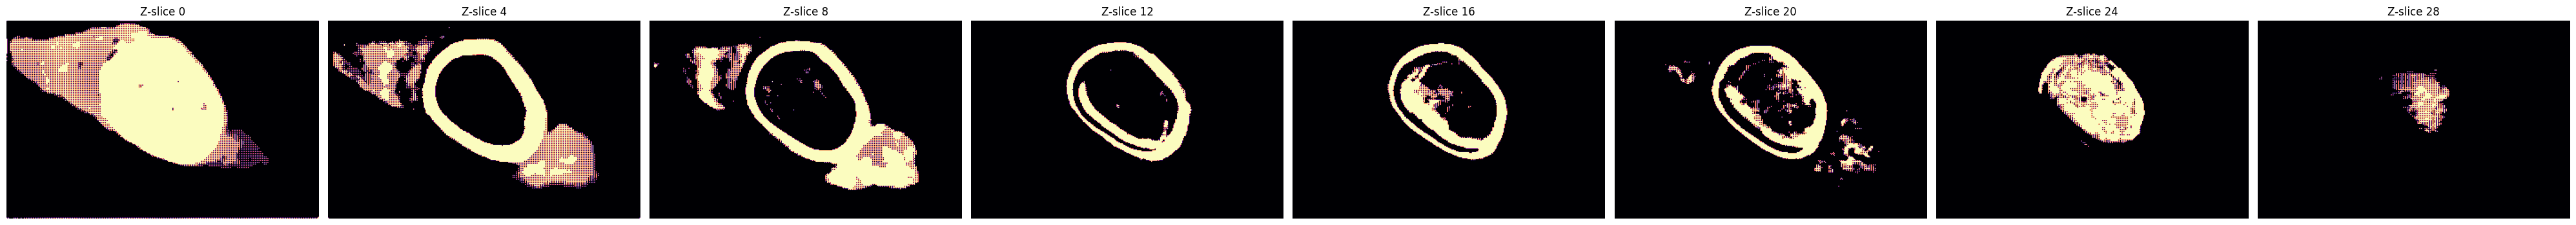

In [28]:
plot_slices(binary_mask)

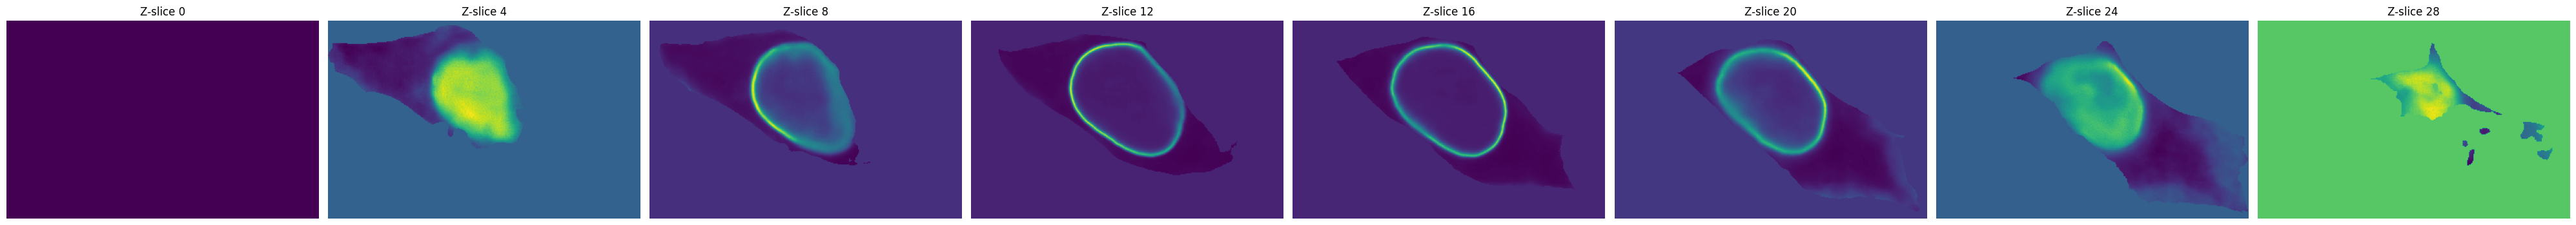

In [29]:
plot_slices(pred, cmap="viridis")

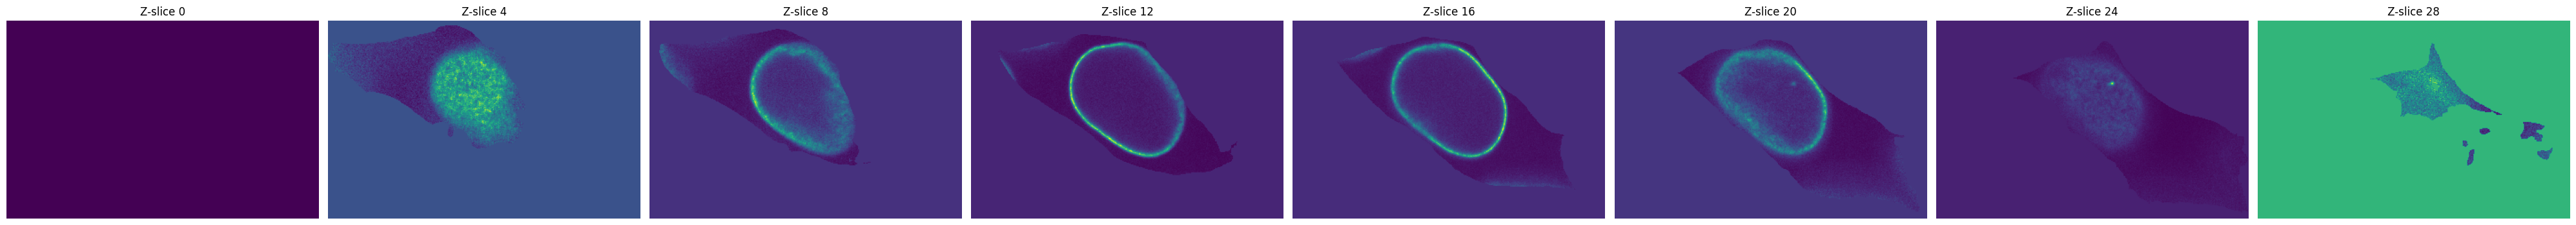

In [30]:
plot_slices(target_patch, cmap="viridis")